In [19]:
import re
from pathlib import Path

import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
from datetime import timedelta

## Define functions

In [20]:
"""
Url this far: 
https://api.hel.fi/linkedevents/v1/event/?start=2019-01-01&end=2019-12-31
&keyword=yso:p1235,yso:p11185,yso:p360,yso:p1808,yso:p965&include=location,keywords&page=1
"""
def extractLinkedEventData(start, end):
    """Calls LinkedEVent API for event data and extracts relevant information from response JSON to dataframe.
    
    All Events that are within start date and end date are contained on result dataframe.
    Event categories that are included can be modifed inside function for now.
    
    film - yso:p1235 
        wellbeing - yso:p1947
        talk - yso:p14004
    concert - yso:p11185
    cultural - yso:p360
    visual art - yso:p2739
        children - yso:p316
        physical training - yso:p916
    lecture - yso:p15875
    music - yso:p1808
    exhibition - yso:p5121
        guidance - yso:p2149
    activism - yso:p10727
    games - yso:p6062
    food - yso:p3670
    dance - yso:p1278
    theatre - yso:p2625
        workshop - yso:p19245
        outdoors - yso:p2771
    sports - yso:p965
        remote - yso:p26626
    
    Parameters
    ----------
    event : String
        Timeframes first date in a following string format: YYYY-MM-DD (ISO 8601)
    end : String
        Timeframes last date in a following string format: YYYY-MM-DD (ISO 8601)
        
    Returns
    -------
        Dataframe of events as rows and event related information as columns.
    """
    
    cat_dict = {'film': 'yso:p1235', 'concert': 'yso:p11185', 'cultural event': 'yso:p360',
                'visual arts': 'yso:p2739', 'lecture': 'yso:p15875', 'music': 'yso:p1808',
                'exhibition': 'yso:p5121', 'activism': 'yso:p10727', 'games': 'yso:p6062',
                'food': 'yso:p3670', 'dance': 'yso:p1278', 'theatre': 'yso:p2625', 'sports': 'yso:p965'}
    cat_names, cat_ids = zip(*cat_dict.items())
    baseurlEvent = 'https://api.hel.fi/linkedevents/v1/event/'
#     categories = ['yso:p1235','yso:p11185','yso:p360','yso:p1808','yso:p965']
    keywordsParam = '&keyword=' + ','.join(cat_ids)
    query = '?start=' + start + '&end=' + end + keywordsParam + '&include=location,keywords&page='
    page = 1

    dataFromJson = list()

    response = requests.get(baseurlEvent + query + str(page))

    meta = response.json()['meta']
    data = response.json()['data']

    while meta['next'] != None:
        for obj in data:
            if obj['location'] == None or obj['location']['position'] == None:
                continue

            id = obj['id']
            longitude = obj['location']['position']['coordinates'][0]
            latitude = obj['location']['position']['coordinates'][1]
            start = obj['start_time']
            end = obj['end_time']
            category = list()
            price = set()

            # Categories are mapped as category columns that contain boolean values 
            #(in numerical format) that indicates if events are classified into the category.
            
            # Get name in this order (en, fi, sv), since only one might be present
            name = obj['name'][sorted(obj['name'].keys())[0]]
            
            for keyword in obj['keywords']:
                if keyword['id'] in cat_ids:
                    category.append(keyword['id'])

            category = list(map(lambda x: int(x in category), cat_ids))

            # Extracts all the prices of the event into a single list
            for offer in obj['offers']:
                if offer['is_free'] == False:
                    if offer['price']:
                        extracted = set()
                        for attribute, value in offer['price'].items():
                            found = list(map(float, re.findall('\d*\.?\d+', value)))
                            extracted.update(found)

                        if len(extracted) > 0:
                            price.update(extracted)
                else:
                    price.add(0)

            # Conditional assignment to make sure min is not taken from empty
            #array in case there is no offers.
            price = np.amin(list(price)) if len(price) > 0 else np.nan

            row = [id, name, longitude, latitude, start, end, *category, price]
            dataFromJson.append(row)

        page += 1
        response = requests.get(baseurlEvent + query + str(page))

        meta = response.json()['meta']
        data = response.json()['data']
        
    columns = ['id', 'name', 'lon', 'lat', 'start_time', 'end_time'] + list(cat_names)
    columns.append('price')

#     column_names = ['Id', 'Longitude', 'Latitude', 'start_time', 'end_time', 
#                     'film', 'concert', 'cultural', 'music', 'sport', 'price']

    return pd.DataFrame(dataFromJson, columns = columns)

def getEventDataToCSVs(years):
    """Collects yearly event information into a dataframe and saves it into csv-file.
    
    csv-files are saved in the execution root with name of 'events-(year).csv'
    
    Parameters
    ----------
    years : Iterable list/array of strings
        each string in list must contain a year number and only year number.
        
    Returns
    -------
        None
    """
    
    for year in years:
        start = f'{year}-04-01'
        end = f'{year}-10-31'
        fileToSave = f'data/events_{start}_{end}.csv'

        df = extractLinkedEventData(start, end)
        df.to_csv(fileToSave, index=False)

In [21]:
# %%time
# getEventDataToCSVs(['2019'])

Than is function to get nearest stations.

In [22]:
def nearest_stations(event, stations, radius=0.5):
    """Finds ids of bike stations nearest to `event`
    
    All stations that are within `radius` will be returned.
    If no stations are found, the nearest one is returned anyway.
    
    Parameters
    ----------
    event : GeoSeries
        Row of a GeoDataFrame of events with Point geometry
    stations : GeoDataFrame
        GeoDataFrame of stations with Point geometry
    radius : int
        Radius of the bounding polygon (in kilometers)
        
    Returns
    -------
        List of bike station ids inside event radius
    """

    # Turn radius to meters
    radius *= 1000
    # Make a 'polygon' around the event 'point' with the above radius
    event_polygon  = event.geometry.buffer(radius)
    # Find all station 'points' inside this polygon
    nearest_stations = stations[stations.within(event_polygon)].index.to_list()
    # Return them as ids if at least one is found
    if nearest_stations:
        return nearest_stations
    # Otherwise find the single nearest station
    nearest_point = nearest_points(event.geometry, stations.geometry.unary_union)[1]
    return stations[stations.geometry == nearest_point].index.to_list()

In [23]:
def bike_ratio(event, trips, td_big=pd.Timedelta(35, 'minutes'), td_small=pd.Timedelta(10, 'minutes')):
    """Calculate the bike ratios for event
    
    Two ratios are returned, one for event start and 
    one for event end. When either ratio is > 1, more bikes
    have come in, than left in the nearby stations.
    
    Parameters
    ----------
    event : GeoSeries
        Row of a GeoDataFrame of events with Point geometry
    trips : pd.DataFrame
        Dataframe of bike trips
    td_big : pd.Timedelta
        Amount of 'padding' before event start and after event end
    td_small : pd.Timedelta
        Amount of 'padding' after event start and before event end
    
    Returns
    -------
    tuple of ints
            start_ratio, end_ratio
    """
    
    # Filter bike trips with the nearest stations
    return_trips = trips[trips['Return station id'].isin(event.stations)]
    departure_trips = trips[trips['Departure station id'].isin(event.stations)]
    
    # Calculate bike ratio for event start
    start1 = event['start_time'] - td_big
    start2 = event['start_time'] + td_small
    start_in = return_trips[(return_trips['Return'] >= start1) &
                            (return_trips['Return'] <= start2)].shape[0]
    start_out = departure_trips[(departure_trips['Departure'] >= start1) &
                                (departure_trips['Departure'] <= start2)].shape[0]
    start_ratio = start_in / max(start_out, 1)
    
    # Calculate bike ratio for event end
    end1 = event['end_time'] - td_small
    end2 = event['end_time'] + td_big
    end_in = return_trips[(return_trips['Return'] >= end1) &
                          (return_trips['Return'] <= end2)].shape[0]
    end_out = departure_trips[(departure_trips['Departure'] >= end1) &
                              (departure_trips['Departure'] <= end2)].shape[0]
    end_ratio = end_in / max(end_out, 1)
    
    return start_ratio, end_ratio

In [24]:
# Find the containing neighborhood for any event's geometry
def containing_neighborhood(point, neighborhoods):
    """Returns index of neighborhood or NaN"""
    try:
        return neighborhoods[neighborhoods.contains(point)].index.item()
    except ValueError:
        return np.nan

## Load and preprocess data

### Bike Trips

In [25]:
%%time
# Read all bike trips for 2019
months = [pd.read_csv(month) for month in Path('data/bike_trips_2019/').iterdir()]
trips = pd.concat(months, ignore_index=True)

# Convert departure and return times to Pandas' Timestamp, 
# which is similar to Python's datetime with additional timezone information.
# Takes 6 min for all 2019 trips
trips['Departure'] = pd.to_datetime(trips['Departure']).apply(lambda x: x.tz_localize('Europe/Helsinki', ambiguous='NaT'))
trips['Return'] = pd.to_datetime(trips['Return']).apply(lambda x: x.tz_localize('Europe/Helsinki', ambiguous='NaT'))

trips.dropna(axis=0, how='any', inplace=True)
trips['Return station id'] = trips['Return station id'].astype('int64')
trips.head(2)

CPU times: user 5min 50s, sys: 2.99 s, total: 5min 53s
Wall time: 5min 55s


,Departure,Return,Departure station id,Departure station name,Return station id,Return station name,Covered distance (m),Duration (sec.)
0,2019-05-31 23:59:59+03:00,2019-06-01 00:11:58+03:00,18,Porthania,43,Karhupuisto,1721.0,714
1,2019-05-31 23:59:58+03:00,2019-06-01 00:21:48+03:00,60,Porkkalankatu,529,Keilaniemi (M),5098.0,1306


### Bike Stations

In [26]:
stations = pd.read_csv('data/bike_stations.csv', index_col=0)
# Turn stations to GeoDataFrame
# Create shapely Points from longitude (x) and latitude (y)
station_points = stations.apply(lambda x: Point(x.lon, x.lat), axis=1)
# Turn df to geopandas df, with the above points as the geometry
# Specify the original coordinate system (CRS), which is in degrees
stations = gpd.GeoDataFrame(stations, geometry=station_points, crs='epsg:4326')
# Turn CRS to Web Mercator, which is in meters
stations.to_crs(epsg=3857, inplace=True)
stations.head(2)

,name,address,city,lat,lon,geometry
id,,,,,,
1,Kaivopuisto,Meritori 1,Helsinki,60.155370,24.950211,POINT (2777444.836 8434410.757)
2,Laivasillankatu,Laivasillankatu 14,Helsinki,60.160989,24.956510,POINT (2778145.960 8435667.883)


### Neighborhoods

In [27]:
# Read neighborhood locations for Helsinki and Espoo (XML/GML)
# neighborhood = kaupunginosa
helsinki = gpd.read_file('https://kartta.hel.fi/ws/geoserver/avoindata/wfs?request=GetFeature&typeName=avoindata:Kaupunginosajako')
espoo = gpd.read_file('https://kartat.espoo.fi/teklaogcweb/wfs.ashx?request=GetFeature&typeName=GIS:Kaupunginosat')
neighborhood_epsg = 3879
helsinki.set_crs(epsg=neighborhood_epsg, inplace=True)
espoo.set_crs(epsg=neighborhood_epsg, inplace=True);

# Preprocess Helsinki
hel = helsinki[['tunnus', 'nimi_fi', 'geometry']].copy()
hel.rename(columns={'nimi_fi': 'name', 'tunnus': 'number'}, inplace=True)
hel.name = hel.name.apply(str.lower)
hel.drop(hel[hel.number == 'Aluemeri'].index, inplace=True)
hel.set_index(hel.number.astype(int), inplace=True)
hel.drop('number', axis=1, inplace=True)
hel.sort_index(inplace=True)

# Preprocess Espoo
esp = espoo.drop(['gml_id', 'KAUPUNGINOSANNIMI_SE'], axis=1)
esp.rename(columns={'KAUPUNGINOSANNIMI_FI': 'name', 'KAUPUNGINOSANNUMERO': 'number'}, inplace=True)
esp.name = esp.name.apply(str.lower)
esp.set_index(esp.number.astype(int), inplace=True)
esp.drop('number', axis=1, inplace=True)
esp.sort_index(inplace=True)

# Join neighborhoods as one
nei = pd.concat([hel, esp], ignore_index=True)
# Helsinki neighborhoods will have their actual 'number' as index, Espoo will have wrong numbers.
nei.index += 1
# Remove neighborhoods that don't have bike stations, except for Eira (6) and Suomenlinna (52)
nei = nei[nei.geometry.apply(lambda x: stations.to_crs(epsg=neighborhood_epsg).within(x).any())]
nei = nei.append(hel.loc[[6, 52]])
nei.sort_index(inplace=True)
nei.head(6)

,name,geometry
1,kruununhaka,"POLYGON ((25497245.691 6673725.015, 25497247.6..."
2,kluuvi,"POLYGON ((25496230.663 6674007.871, 25496260.2..."
3,kaartinkaupunki,"POLYGON ((25496735.972 6672760.566, 25496754.8..."
4,kamppi,"POLYGON ((25495593.942 6672440.069, 25495597.9..."
5,punavuori,"POLYGON ((25495960.748 6671953.785, 25495956.6..."
6,eira,"POLYGON ((25496320.850 6671637.111, 25496298.1..."


<AxesSubplot:>

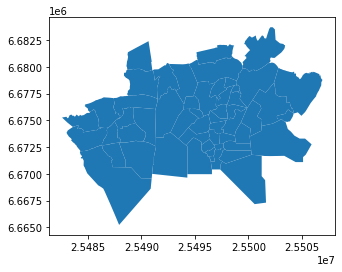

In [28]:
nei.plot()

### Events

In [29]:
%%time
events = pd.read_csv('data/events_2019-04-01_2019-10-31.csv')
print('Number of events before preprocessing:', events.shape[0])

# Convert event Timestamps to the the same timezone as bike trips
events['start_time'] = pd.to_datetime(events['start_time'], utc=True).apply(lambda x: x.tz_convert('Europe/Helsinki'))
events['end_time'] = pd.to_datetime(events['end_time'], utc=True).apply(lambda x: x.tz_convert('Europe/Helsinki'))

# Drop events with missing start or end time
events.drop(events.index[events['start_time'].isnull() |
                         events['end_time'].isnull()], inplace=True)

# Drop events that don't match the city bike season (April - October)
events.drop(events.index[(events['start_time'] > trips['Departure'].max()) |
                         (events['end_time'] < trips['Departure'].min())], inplace=True)

# Drop  events that are longer than 24 hours
events.drop(events.index[events['end_time'] - events['start_time'] > pd.Timedelta(1, 'days')], inplace=True)

# Turn events to GeoDataFrame
event_points = events.apply(lambda x: Point(x.lon, x.lat), axis=1)
events = gpd.GeoDataFrame(events, geometry=event_points, crs='epsg:4326')
events.to_crs(epsg=3857, inplace=True)

# Add the number of the surrounding neighborhood to each event
events['neighborhood'] = events.to_crs(epsg=neighborhood_epsg).geometry.apply(lambda x: containing_neighborhood(x, nei))

# Drop events that are not found inside filtered neighborhoods
# This drops all events in Vantaa (no bike trip data), 
# and some events in Espoo that are far away from bike stations.
events.drop(events.index[events['neighborhood'].isnull()], inplace=True)
events['neighborhood'] = events['neighborhood'].astype(int)

# Drop duplicate events by name
events.drop_duplicates('name', keep='first', inplace=True, ignore_index=True)

print('Number of events after preprocessing:', events.shape[0])            
events.head(2)

Number of events before preprocessing: 6228
Number of events after preprocessing: 1266
CPU times: user 3.07 s, sys: 9.9 ms, total: 3.08 s
Wall time: 3.11 s


,id,name,lon,lat,start_time,end_time,film,concert,cultural event,visual arts,...,exhibition,activism,games,food,dance,theatre,sports,price,geometry,neighborhood
0,lippupiste:serie-2347167,Paradisdoktrinen,24.937542,60.167675,2019-05-15 19:00:00+03:00,2019-05-16 03:00:00+03:00,0,0,0,0,...,0,0,0,0,0,1,0,NaN,POINT (2776034.477 8437163.868),4
1,helsinki:afu35fjagi,Työväenopiston laulajien kevätkonsertti,24.887007,60.217213,2019-04-03 18:15:00+03:00,2019-04-03 19:15:00+03:00,0,1,0,0,...,0,0,0,0,0,0,0,0.0,POINT (2770408.947 8448257.561),29


In [30]:
print('Neighbordhoods with most events:')
display(events.neighborhood.value_counts().head(5))
display(nei.loc[events.neighborhood.value_counts().head(5).index, 'name'])

Neighbordhoods with most events:


86    154
61    128
12    119
4     104
2     103
Name: neighborhood, dtype: int64

86    leppävaara
61       tapiola
12    alppiharju
4         kamppi
2         kluuvi
Name: name, dtype: object

#### Calculate nearest stations for remaining events (500 m radius)


In [31]:
events['stations'] = events.apply(lambda x: nearest_stations(x, stations, radius=0.5), axis=1)

## Calculate bike ratio

In [32]:
%%time
# Calculate bike ratios
events[['start_ratio', 'end_ratio']] = events.apply(lambda x: bike_ratio(x, trips), axis=1).apply(pd.Series)

CPU times: user 40.8 s, sys: 76.5 ms, total: 40.9 s
Wall time: 41.3 s


In [33]:
# We would expect `end_ratio` to be smaller than `start_ratio` for each event,
# since more bikes should be leaving at event end than at event start.
events.head()

,id,name,lon,lat,start_time,end_time,film,concert,cultural event,visual arts,...,food,dance,theatre,sports,price,geometry,neighborhood,stations,start_ratio,end_ratio
0,lippupiste:serie-2347167,Paradisdoktrinen,24.937542,60.167675,2019-05-15 19:00:00+03:00,2019-05-16 03:00:00+03:00,0,0,0,0,...,0,0,1,0,NaN,POINT (2776034.477 8437163.868),4,"[24, 27]",1.083333,0.0
1,helsinki:afu35fjagi,Työväenopiston laulajien kevätkonsertti,24.887007,60.217213,2019-04-03 18:15:00+03:00,2019-04-03 19:15:00+03:00,0,1,0,0,...,0,0,0,0,0.0,POINT (2770408.947 8448257.561),29,[213],0.000000,0.0
2,helsinki:afu35gqdze,Kulttuuriluento - Fjodor Dostojevskin teos Idi...,24.887007,60.217213,2019-04-08 14:30:00+03:00,2019-04-08 14:30:00+03:00,0,0,0,0,...,0,0,0,0,0.0,POINT (2770408.947 8448257.561),29,[213],0.000000,0.0
3,helsinki:afu35it53e,Veteraanipäivän konsertti,24.887007,60.217213,2019-04-26 13:15:00+03:00,2019-04-26 14:00:00+03:00,0,1,0,0,...,0,0,0,0,0.0,POINT (2770408.947 8448257.561),29,[213],0.500000,0.0
4,helsinki:afu35jl35m,Kallion laulu -kuoron konsertti,24.887007,60.217213,2019-04-29 17:15:00+03:00,2019-04-29 18:00:00+03:00,0,1,0,0,...,0,0,0,0,0.0,POINT (2770408.947 8448257.561),29,[213],1.500000,1.5


In [34]:
events.start_ratio.describe()

count    1266.000000
mean        1.117515
std         1.321471
min         0.000000
25%         0.428571
50%         1.000000
75%         1.333333
max        19.000000
Name: start_ratio, dtype: float64

In [35]:
# events.drop('geometry', axis=1).to_csv('data/events_with_ratios_2019.csv', index=False)